In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,602 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

# 1. TF-IDF 기반의 앙상블 분류 모델 구축

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from scipy.stats import randint
from sklearn.feature_selection import chi2, SelectKBest
import re
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk
nltk.download('all')

train = pd.read_csv('/content/drive/MyDrive/Data/project_data/train_40k.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/project_data/val_10k.csv')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [4]:
train.columns

Index(['productId', 'Title', 'userId', 'Helpfulness', 'Score', 'Time', 'Text',
       'Cat1', 'Cat2', 'Cat3'],
      dtype='object')

In [5]:
## 데이터의 문장 길이 시긱화
def length_text(data, title):
    print('길이의 최댓값:{}'.format(np.max(data)))
    print('길이의 최솟값:{}'.format(np.min(data)))
    print('길이의 평균값:{}'.format(np.mean(data)))
    print('길이의 표준편차:{}'.format(np.std(data)))
    print('길이의 중간값:{}'.format(np.median(data)))

    plt.figure(figsize = (20, 10))
    plt.hist(data, bins = 200, alpha = 0.5, color = 'r', label = 'word')
    plt.yscale('log', nonposy = 'clip')
    plt.title(title, fontsize = 30)
    plt.xlabel('Length of Review', fontsize = 20)
    plt.ylabel('Number of Review', fontsize = 20)
    
    return plt.show()

## 데이터의 사분위 값 시각화
def length_text2(data, title):
    print('길이의 최댓값:{}'.format(np.max(data)))
    print('길이의 최솟값:{}'.format(np.min(data)))
    print('길이의 평균값:{}'.format(np.mean(data)))
    print('길이의 표준편차:{}'.format(np.std(data)))
    print('길이의 중간값:{}'.format(np.median(data)))

    plt.figure(figsize = (20, 10))
    plt.boxplot(data, labels = ['counts'], showmeans = True)
    plt.title(title, fontsize = 30)

    return plt.show()

## 단어 빈도 수 시각화
def text_size(data):
    data_review = [review for review in data if type(review) is str]
    wordcloud = WordCloud('NanumGothic.ttf').generate(' '.join(data_review))
    plt.figure(figsize = (20, 10))
    plt.title('Word frequency', fontsize = 30)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    return plt.show()

In [6]:
length = train['Text'].astype('str').apply(len)
train_word_counts = train['Text'].astype(str).apply(lambda x : len(x.split(' ')))

길이의 최댓값:6589
길이의 최솟값:1
길이의 평균값:435.201875
길이의 표준편차:389.34721152396565
길이의 중간값:323.0


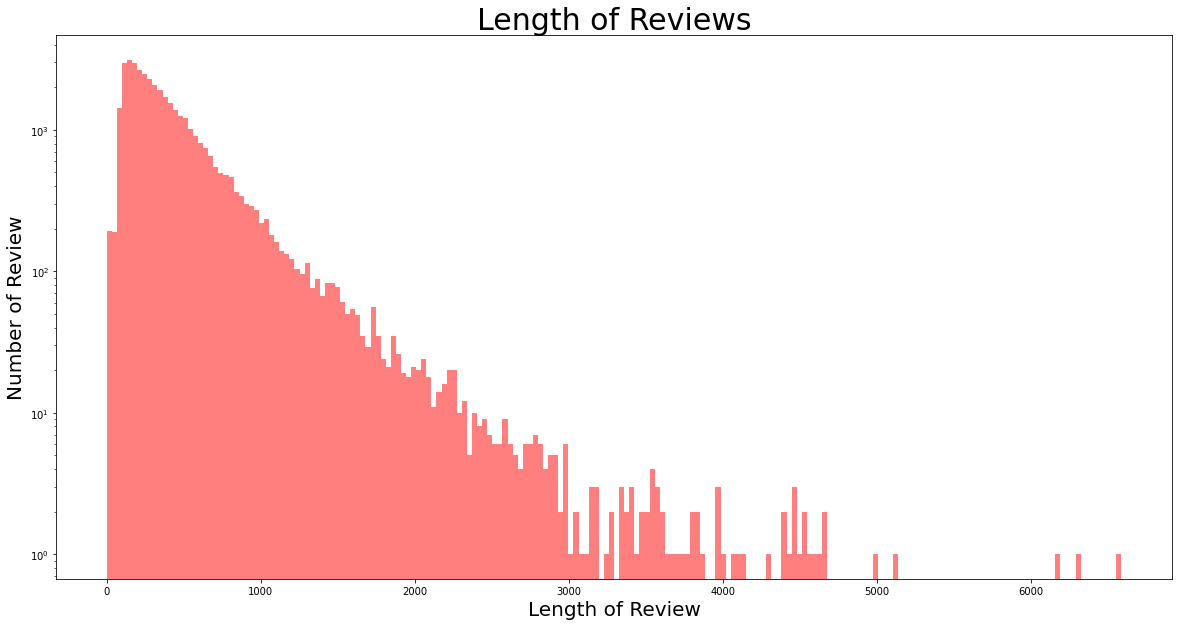

길이의 최댓값:6589
길이의 최솟값:1
길이의 평균값:435.201875
길이의 표준편차:389.34721152396565
길이의 중간값:323.0


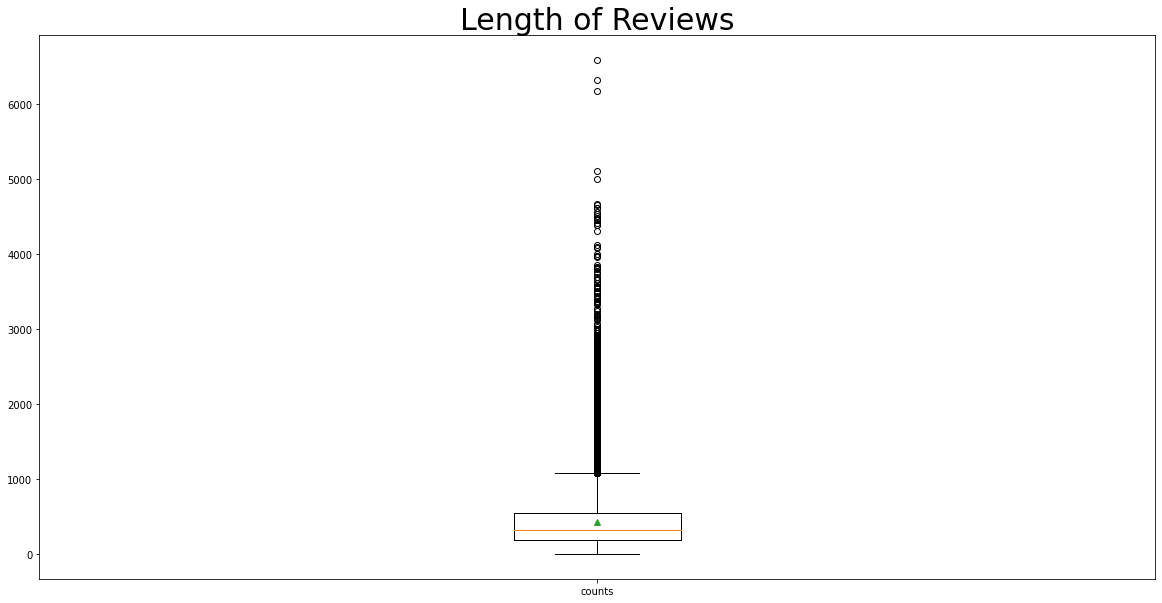

(None, None)

In [7]:
length_text(length, 'Length of Reviews'), length_text2(length, 'Length of Reviews')

길이의 최댓값:1149
길이의 최솟값:1
길이의 평균값:82.361075
길이의 표준편차:72.7022540905318
길이의 중간값:62.0


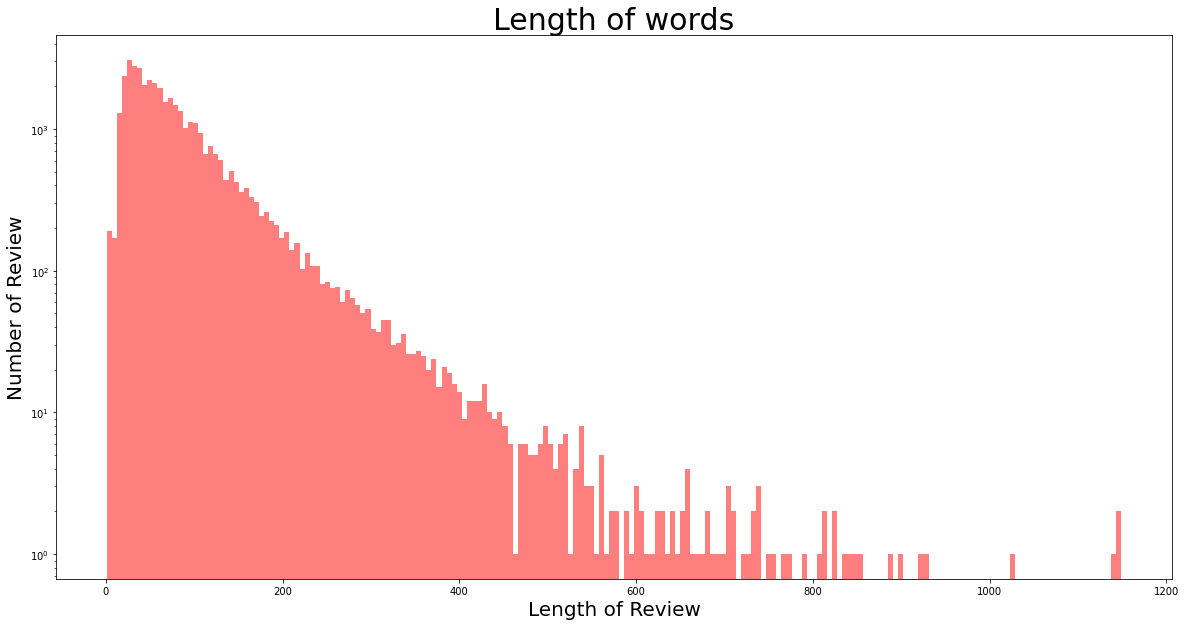

길이의 최댓값:1149
길이의 최솟값:1
길이의 평균값:82.361075
길이의 표준편차:72.7022540905318
길이의 중간값:62.0


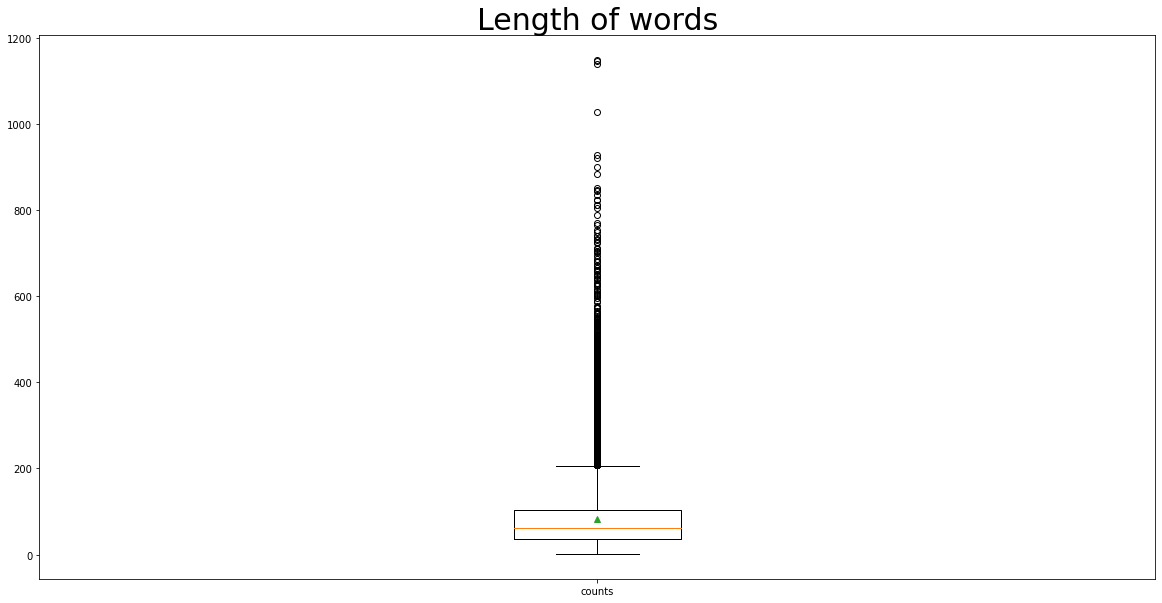

In [8]:
length_text(train_word_counts, 'Length of words'), 
length_text2(train_word_counts, 'Length of words')

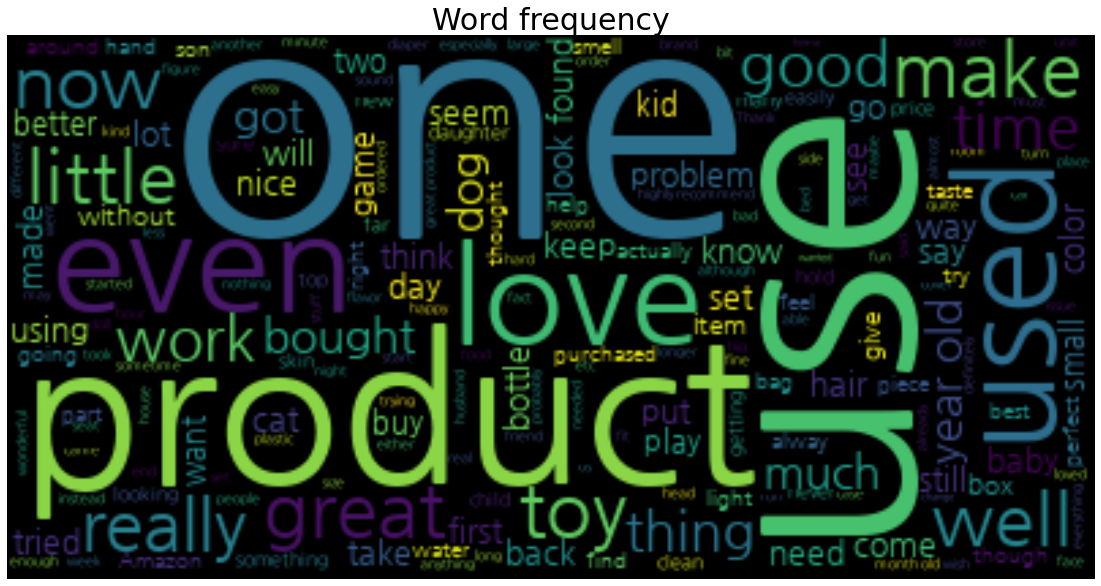

In [ ]:
text_size(train['Text'])

In [9]:
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'their', 'more', 'this', 'haven', 'they', 'did', 'being', 'll', 'down', 'm', 'once', 'yourself', "weren't", 'which', 'but', "you've", 'before', 'shan', 'he', "should've", 'again', "haven't", 'wouldn', 'yourselves', 'during', "hadn't", 'the', 'mustn', 'isn', 'me', 'won', 'own', 'your', 'through', 'most', 'whom', 'over', 'ma', 'she', 's', 'after', 'it', 'what', 'where', "aren't", 'and', 'myself', 'ourselves', "you're", 'hadn', 'with', 'that', 'mightn', 'than', "isn't", 'below', 're', 'ours', "needn't", 'her', 'we', 'my', 'how', 'its', 'both', 'can', 'does', 'themselves', 'is', 'has', 'for', 'd', 'at', 'if', "don't", 'other', 'had', 'some', 'just', 'will', 'too', 'no', 'hasn', 'doesn', 'hers', 'am', 'be', 'didn', 'an', 'our', 'o', "it's", 'only', "mightn't", 'on', 't', 'such', 'while', "you'll", 'between', 'yours', "shan't", "won't", 'from', "she's", 'to', "that'll", 'herself', 'were', 'i', 'out', 'further', 'same', 'have', 'needn', 'not', "wouldn't", 'his', 've', 'under', '

In [10]:
def clean_text(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
train['Text'] = train['Text'].apply(clean_text)
test['Text'] = test['Text'].apply(clean_text)

In [12]:
length_eda = train['Text'].astype('str').apply(len)
train_word_counts_eda = train['Text'].astype(str).apply(lambda x : len(x.split(' ')))

In [13]:
train['length'] = train['Text'].apply(lambda x : len(x)) ## 최솟값이 0으로 나오기 때문에 0인값을 추출해본다.

In [14]:
train['word_len'] = train['Text'].apply(lambda x : x.split()).apply(lambda x : len(x))

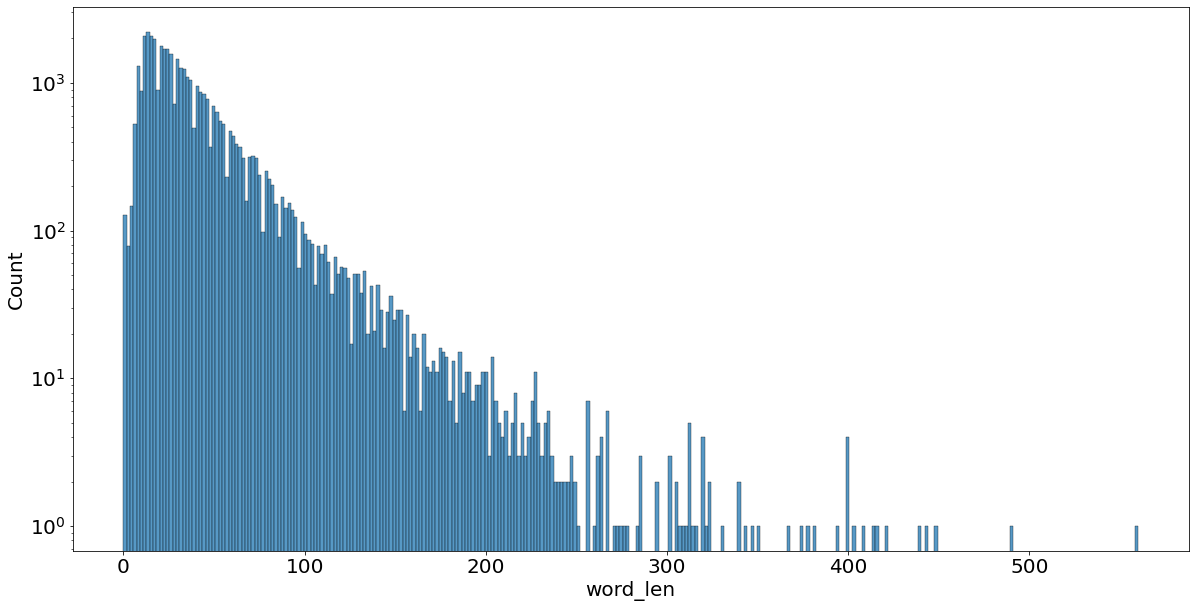

In [15]:
plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.yscale('log')
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
sns.histplot(train['word_len'])

In [16]:
train['length'].describe()

count    40000.000000
mean       250.908525
std        222.558874
min          0.000000
25%        111.000000
50%        187.000000
75%        314.000000
max       4098.000000
Name: length, dtype: float64

In [17]:
train = train[train['word_len'] > 10]
train

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3,length,word_len
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,description photo product needs changed indica...,grocery gourmet food,meat poultry,jerky,84,11
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,great book well thought easily imagine events ...,toys games,games,unknown,167,25
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,first year teacher teaching th grade special r...,toys games,games,unknown,320,49
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,got book bookfair school looking something sum...,toys games,games,unknown,299,42
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,hi martine redman created puzzle briarpatch us...,toys games,puzzles,jigsaw puzzles,460,63
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,B0006IYND6,Japonesque Silver Lipstick Palette Kit 1 piece,A1WKFQYYRJ95F6,0/0,3.0,1344211200,even convenient find really small store tiny a...,beauty,makeup,lips,94,14
39996,B000A33FZY,"Truform 20-30 Below Knee Closed-Toe, Beige, Small",A1OMZID10X2JY4,0/0,5.0,1344211200,wore next day eating chinese take ankles went ...,health personal care,medical supplies equipment,braces,87,15
39997,B000I7D2L4,Zadro Z300 Wall Mountable Fog Free Mirror,A3I8EYB4CKPQVO,0/0,3.0,1344211200,ok product really stay fog free long useful co...,beauty,tools accessories,mirrors,61,11
39998,B000KHKKB2,Opalescent Glitter Lotion - 6.3 oz - Liquid,A3GTQQ5ZFCFBBL,0/0,4.0,1344211200,glitter body lotion offers tremendous sparkle ...,beauty,skin care,body,299,42


In [18]:
token = Tokenizer()
token.fit_on_texts(train['Text'])

In [19]:
threshold = 8
total_cnt = len(token.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in token.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 44545
등장 빈도가 7번 이하인 희귀 단어의 수: 33602
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10943
단어 집합에서 희귀 단어의 비율: 75.43383095745875
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.411862024421815


In [20]:
X_train, X_val, y_train1, y_val1 = train_test_split(train[['Text']], train[['Cat1']], test_size= 0.2, random_state = 411)
X_train.shape, X_val.shape, y_train1.shape, y_val1.shape

((29555, 1), (7389, 1), (29555, 1), (7389, 1))

In [21]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

y_train1 = enc.fit_transform(y_train1[['Cat1']])
y_val1 = enc.transform(y_val1[['Cat1']])
y_test1 = enc.transform(test[['Cat1']])

y_train1

array([[4.],
       [2.],
       [5.],
       ...,
       [5.],
       [0.],
       [5.]])

## 1-2. RandomForest 모델 비교

In [23]:
vect = TfidfVectorizer(stop_words = 'english')

chi = SelectKBest(chi2, k = 10000)

rfc = RandomForestClassifier(random_state=411)



pipe = Pipeline([
                        ('vect', vect),
                        ('chi', chi),
                        ('rfc', rfc)
])

In [27]:
pipe.fit(X_train['Text'], y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [81]:
y_pred_val = pipe.predict(X_val['Text'])
y_pred_test = pipe.predict(test['Text'])
rfc_acc_val = accuracy_score(y_val1, y_pred_val)
rfc_acc_test = accuracy_score(y_test1, y_pred_test)
rfc_f1_val = f1_score(y_val1, y_pred_val, average='macro')
rfc_f1_test = f1_score(y_test1, y_pred_test, average='macro')
rfc_train = pipe.score(X_train['Text'], y_train1)

print('랜덤포레스트 훈련 정확도:', rfc_train)
print('랜덤포레스트 검증 정확도:', rfc_acc_val)
print('랜덤포레스트 테스트 정확도:', rfc_acc_test)
print('랜덤포레스트 검증 f1:', rfc_f1_val)
print('랜덤포레스트 테스트 f1:', rfc_f1_test)


랜덤포레스트 훈련 정확도: 0.9999323295550668
랜덤포레스트 검증 정확도: 0.7895520368114766
랜덤포레스트 테스트 정확도: 0.7236
랜덤포레스트 검증 f1: 0.7863369602291769
랜덤포레스트 테스트 f1: 0.7110072014319773


In [42]:
parameter = {'vect__max_df' : (0.5, 0.7, 0.9, 1),
             'vect__min_df' : (1, 2, 3, 4, 5),
             'vect__max_features' : (5000, 8000, 10000, 12000, None),
             'rfc__max_depth' : (3, 5, 7, 9, None)
             }

model = GridSearchCV(pipe,
                     param_grid = parameter,
                     refit = True,
                     cv = 3,
                     scoring = 'accuracy',
                     verbose = 1,
                     n_jobs = -1)

model.fit(X_train['Text'], y_train1)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 30.9min finished
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [43]:
model.best_score_

0.7809169076954018

In [44]:
model.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [82]:
best = model.best_estimator_

y_pred_val = best.predict(X_val['Text'])
y_pred_test = best.predict(test['Text'])
rfc_acc_val_cv = accuracy_score(y_val1, y_pred_val)
rfc_acc_test_cv = accuracy_score(y_test1, y_pred_test)
rfc_f1_val_cv = f1_score(y_val1, y_pred_val, average='macro')
rfc_f1_test_cv = f1_score(y_test1, y_pred_test, average='macro')
rfc_train_cv = best.score(X_train['Text'], y_train1)

print('랜덤포레스트 CV 훈련 정확도:', rfc_train_cv)
print('랜덤포레스트 CV 검증 정확도:', rfc_acc_val_cv)
print('랜덤포레스트 CV테스트 정확도:', rfc_acc_test_cv)
print('랜덤포레스트 CV 검증 f1:', rfc_f1_val_cv)
print('랜덤포레스트 CV 테스트 f1:', rfc_f1_test_cv)


랜덤포레스트 CV 훈련 정확도: 0.9999323295550668
랜덤포레스트 CV 검증 정확도: 0.7895520368114766
랜덤포레스트 CV테스트 정확도: 0.7236
랜덤포레스트 CV 검증 f1: 0.7863369602291769
랜덤포레스트 CV 테스트 f1: 0.7110072014319773


파이프라인 구축 후, GridSearch CV를 통해 교차 검증 실시 및 최적의 하이퍼파라미터로 튜닝을 진행하였다. 그 결과 검증 정확도는 대략 0.78로 나오고, 테스트 정확도는 0.72로 나왔다. 훈련 정확도에 비해 검증 정확도나 테스트 정확도의 차이가 많이 났다. 과적합이 이루어진 것을 확인할 수 있다. XGBoost도 동일하게 진행해보겠다.

In [38]:
from sklearn.feature_selection import chi2 as chi

vect = TfidfVectorizer(stop_words = 'english')

chi = SelectKBest(chi, k = 10000)

xgb = XGBClassifier(random_state=411)



pipe_xgb = Pipeline([
                        ('vect', vect),
                        ('chi', chi),
                        ('xgb', xgb)
])

In [39]:
pipe_xgb.fit(X_train['Text'], y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                        

In [83]:
y_pred_val = pipe_xgb.predict(X_val['Text'])
y_pred_test = pipe_xgb.predict(test['Text'])
xgb_acc_val = accuracy_score(y_val1, y_pred_val)
xgb_acc_test = accuracy_score(y_test1, y_pred_test)
xgb_f1_val = f1_score(y_val1, y_pred_val, average='macro')
xgb_f1_test = f1_score(y_test1, y_pred_test, average='macro')
xgb_train = pipe_xgb.score(X_train['Text'], y_train1)

print('XGBoost 훈련 정확도:', xgb_train)
print('XGBoost 검증 정확도:', xgb_acc_val)
print('XGBoost 테스트 정확도:', xgb_acc_test)
print('XGBoost 검증 f1:', xgb_f1_val)
print('XGBoost 테스트 f1:', xgb_f1_test)

XGBoost 훈련 정확도: 0.7519201488749788
XGBoost 검증 정확도: 0.7337934767898228
XGBoost 테스트 정확도: 0.6731
XGBoost 검증 f1: 0.7332307860037902
XGBoost 테스트 f1: 0.6645774368618164


In [41]:
parameter = {'vect__max_df' : (0.7, 1),
             'vect__min_df' : (1, 3, 5),
             'vect__max_features' : (10000, 12000, None),
             'xgb__max_depth' : (5, 7, None)
             }

model_xgb = GridSearchCV(pipe_xgb,
                     param_grid = parameter,
                     refit = True,
                     cv = 3,
                     scoring = 'accuracy',
                     verbose = 1,
                     n_jobs = -1)

model_xgb.fit(X_train['Text'], y_train1)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 20.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [47]:
model_xgb.best_score_

0.7748265538991386

In [48]:
model_xgb.best_params_

{'vect__max_df': 0.7,
 'vect__max_features': 10000,
 'vect__min_df': 1,
 'xgb__max_depth': 7}

In [84]:
best_xgb = model_xgb.best_estimator_
y_pred_val = best_xgb.predict(X_val['Text'])
y_pred_test = best_xgb.predict(test['Text'])
xgb_acc_val_cv = accuracy_score(y_val1, y_pred_val)
xgb_acc_test_cv = accuracy_score(y_test1, y_pred_test)
xgb_f1_val_cv = f1_score(y_val1, y_pred_val, average='macro')
xgb_f1_test_cv = f1_score(y_test1, y_pred_test, average='macro')
xgb_train_cv = best_xgb.score(X_train['Text'], y_train1)

print('XGBoost CV 훈련 정확도:', xgb_train_cv)
print('XGBoost CV 검증 정확도:', xgb_acc_val_cv)
print('XGBoost CV 테스트 정확도:', xgb_acc_test_cv)
print('XGBoost CV 검증 f1:', xgb_f1_val_cv)
print('XGBoost CV 테스트 f1:', xgb_f1_test_cv)

XGBoost CV 훈련 정확도: 0.8351886313652512
XGBoost CV 검증 정확도: 0.7822438760319393
XGBoost CV 테스트 정확도: 0.7215
XGBoost CV 검증 f1: 0.7838901279808095
XGBoost CV 테스트 f1: 0.7153369549741858


In [85]:
score = pd.DataFrame({'Score' :['train_acc','val_acc', 'test_acc', 'val_f1', 'test_f1'],
              'RFC':[rfc_train, rfc_acc_val, rfc_acc_test, rfc_f1_val, rfc_f1_test], 
              'RFC_CV': [rfc_train_cv, rfc_acc_val_cv, rfc_acc_test_cv, rfc_f1_val_cv, rfc_f1_test_cv],
              'XGB':[xgb_train, xgb_acc_val, xgb_acc_test, xgb_f1_val, xgb_f1_test], 
              'XGB_CV': [xgb_train_cv, xgb_acc_val_cv, xgb_acc_test_cv, xgb_f1_val_cv, xgb_f1_test_cv]})

score

,Score,RFC,RFC_CV,XGB,XGB_CV
0,train_acc,0.999932,0.999932,0.751920,0.835189
1,val_acc,0.789552,0.789552,0.733793,0.782244
2,test_acc,0.723600,0.723600,0.673100,0.721500
3,val_f1,0.786337,0.786337,0.733231,0.783890
4,test_f1,0.711007,0.711007,0.664577,0.715337


앙상블 랜덤포레스트와 XGBoost 모델을 구현한 후, GridSearchCV를 진행하여 교차 검증 및 하이퍼파라미터 튜닝을 한 정확도를 도출하였다.

 그 결과, XGBoost에서 GridSearchCV를 진행한 모델이 가장 성능이 좋았다. 뿐만 아니라, XGBoost 모델보다 랜덤포레스트 모델이 과적합 된 것을 볼 수 있었다. 
 그러므로, XGBoost CV 모델이 랜덤포레스트 보다 상대적으로 일반화할 수 있는 모델임을 알 수 있다.
 하지만 성능 자체가 0.72~0.78이기 때문에 실제 적용할 수 있는 모델로 보기엔 어려움이 있다는 생각이 든다. 그래서 딥러닝 모델을 구현하여 실제 성능을 비교해보도록 하겠다.